# Imports

In [1]:
import os
import numpy as np
import gymnasium as gym
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

from gymnasium.utils.save_video import save_video

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Environment

Create the [environment](https://gymnasium.farama.org/environments/box2d/bipedal_walker/).

In [3]:
env_name = 'BipedalWalker-v3'

In [4]:
enviroment = gym.make(env_name, render_mode='rgb_array', hardcore=False)
eval_enviroment = gym.make(env_name, hardcore=False)

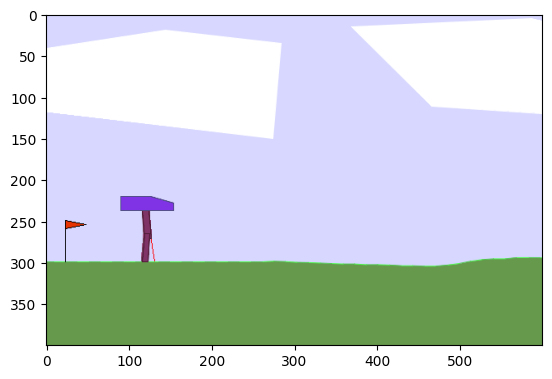

In [5]:
enviroment.reset()
plt.imshow(enviroment.render())

# Replay Buffer

Create a replay buffer to hold game history

In [6]:
class ReplayBuffer:

    def __init__(self, max_size: int, observation_space: gym.spaces.Space, action_space: gym.spaces.Space, seed: int | None = None):
        """Stores the replay history with a maximum of `max_size` entries, removing old entries as needed.

        Parameters:
            max_size: maximal number of entries to keep
            observation_space: specification of the observation space
            action_space: specification of the action space
            seed: seed to initialize the internal random number generator for reproducibility"""

        self.max_size = max_size
        
        self.done = np.zeros(max_size)
        self.rng = np.random.default_rng(seed=seed)
        
        self.step = 0
        self.len = 0

        self.action = np.zeros((max_size, *action_space.shape), dtype=int)
        self.reward = np.zeros(max_size)

        self.current_state = np.zeros((max_size, *observation_space.shape))
        self.next_state = np.zeros((max_size, *observation_space.shape))

    def add(self, current_observation: np.ndarray, action: np.ndarray, reward: float, next_observation: np.ndarray, done: bool) -> None:
        """Add a new entry to the buffer.

        Parameters:
            current_observation: environment state observed at the current step
            action: action taken by the model
            reward: reward received after taking the action
            next_observation: environment state obversed after taking the action
            done: whether the episode has ended or not"""
        
        self.current_state[self.step] = current_observation
        self.action[self.step] = action
        self.reward[self.step] = reward
        self.next_state[self.step] = next_observation
        self.done[self.step] = done
        self.step = (self.step + 1) % self.max_size
        self.len = min(self.len + 1, self.max_size)
        
    def sample(self, n_samples: int, replace: bool = True) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Randomly samples `n_samples` from the buffer.

        Parameters:
            n_samples: number of samples to select
            replace: sample with or without replacement

        Returns:
            current observations, actions, rewards, next observations, done"""
        indicies = self.rng.choice(self.len, size=n_samples, replace=replace)
        
        return (
            self.current_state[indicies],
            self.action[indicies],
            self.reward[indicies],
            self.next_state[indicies],
            self.done[indicies]
        )

    def clear(self) -> None:
        """Clears the buffer"""
        self.step = 0
        self.len = 0

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Gets a sample at `index`

        Parameters:
            index: index of the sample to get

        Returns:
            current observation, action, reward, next observation, done"""
        return (
            self.current_state[index], 
            self.action[index], 
            self.reward[index], 
            self.next_state[index], 
            self.done[index]
        )
        
    def __len__(self) -> int:
        """Returns the number of entries in the buffer"""
        return self.len

# Model

Implement your model

In [7]:
def get_name(prefix: str | None = None, suffix: str | None = None, separator: str = '/') -> str | None:
    return prefix and prefix + separator + suffix or suffix or None

In [8]:
def get_model(
    input_features: int,
    a_features: tuple,
    features: int,
    out_features: tuple,
    blocks: int, 
    activation: str | tf.keras.layers.Activation | None = 'silu',
    dropout: float = 0.4,
    multiply_freq: int = 1,
    kind_of_model: str | None = None,
    name: str | None = None
) -> tf.keras.Model:

    if kind_of_model == 'policy':
        inputs = x = tf.keras.layers.Input(input_features, name=get_name(name, 'obs_input'))
    else:
        obs_input = tf.keras.layers.Input(input_features, name=get_name(name, 'obs_input'))
        a_input = tf.keras.layers.Input(a_features, name=get_name(name, 'a_input'))
        
        inputs = [obs_input, a_input]
        x = tf.keras.layers.Concatenate()(inputs)

    for i in range(blocks):
        x = tf.keras.layers.Dense(features, activation=activation, name=get_name(name, f'Dense_f_{i}'))(x)
        x = tf.keras.layers.Dense(features * 2, activation=activation, name=get_name(name, f'Dense_s_{i}'))(x)

        if multiply_freq > 0 and (i + 1) % multiply_freq == 0:
            features *= 2

        if dropout > 0:
            x = tf.keras.layers.Dropout(dropout, name=get_name(name, f'Dropout_{i}'))(x)

    if kind_of_model == 'policy':
        x = tf.keras.layers.Dense(out_features, activation='tanh', name=get_name(name, 'Prediction'))(x)
    else:
        x = tf.keras.layers.Dense(out_features, name=get_name(name, 'Prediction'))(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x, name=name)

# Play the game

Implement interacting with the environment and storing entries to the replay buffer

In [9]:
def play_game(model: tf.keras.Model, buffer: ReplayBuffer | None, env: gym.Env, max_steps: int, observation: np.ndarray | None = None) -> np.ndarray:
    """Play game and record

    Parameters:
        model: the model to get actions with
        buffer: replay buffer to store the entries to
        env: environment to play
        max_steps: maximal number of steps to perform
        observation: the observation to resume from

    Returns:
        the last observation"""
    if observation is None:
        observation, _ = env.reset()

    buffer = buffer if buffer is not None else ReplayBuffer(1)

    for _ in range(max_steps):
        a = model(observation[None], training=False).numpy()[0] # Observe state `s` and select action `a`
        a = tf.clip_by_value(a + tf.random.normal((4,)).numpy(), -1.0, 1.0)
        
        new_observation, score, done, terminated, _ = env.step(a) # Execute `a` in the environment
        
        buffer.add(observation, a, score, new_observation, done) # Store `(s, a, r, s', d)` in buffer

        if done or terminated: # If `s'` is terminal, reset environment state
            observation, _ = env.reset()
            continue
            
        observation = new_observation

    return observation

# Loss

In [10]:
def ddpg_loss(
    current_observation: tf.Tensor, 
    action: tf.Tensor, 
    reward: tf.Tensor, 
    next_observation: tf.Tensor,
    done: tf.Tensor,
    q_model: tf.keras.Model,
    policy_model: tf.keras.Model,
    target_q_model: tf.keras.Model,
    target_policy_model: tf.keras.Model,
    gamma: float
) -> tuple[tf.Tensor, tf.Tensor]:
    """Computes Deep Deterministic Policy Gradient.

    Parameters:
        current_observation: observations at the current time step
        action: actions taken at the current time step
        reward: rewards at the current time step
        next_observation: observations at the next time step
        done: whether the episode has ended or not
        q_model: q-function model
        policy_model: action prediction model
        target_q_model: target q-function model
        target_policy_model: target action prediction model
        gamma: discount

    Returns:
        Computed losses for q-function and policy models"""
    
    q_current = q_model((current_observation, action))
    q_next = target_q_model((next_observation, target_policy_model(next_observation)))

    q_ref = reward + gamma * (1. - done) * q_next
    q_loss = tf.math.reduce_mean(tf.square(q_current - q_ref))

    policy_loss = -tf.math.reduce_mean(q_model((current_observation, policy_model(current_observation))))

    return q_loss, policy_loss

# Training

Create models, replay buffers, optimizer. Implement training loop, show training progress and perform model evaluation once in a while

In [11]:
model = get_model(enviroment.observation_space.shape[0], enviroment.action_space.shape, 256, 1, 5, name='Timofeev_Andrey', dropout=0.2, multiply_freq=2, activation='relu')
model.summary()

Model: "Timofeev_Andrey"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Timofeev_Andrey/obs_input (Inp  [(None, 24)]        0           []                               
 utLayer)                                                                                         
                                                                                                  
 Timofeev_Andrey/a_input (Input  [(None, 4)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 concatenate (Concatenate)      (None, 28)           0           ['Timofeev_Andrey/obs_input[0][0]
                                                                 ',                 

In [12]:
target_model = get_model(enviroment.observation_space.shape[0], enviroment.action_space.shape, 256, 1, 5, name='Target_Timofeev_Andrey', multiply_freq=2, activation='relu')
target_model.trainable = False
target_model.set_weights(model.get_weights())

In [13]:
policy_model = get_model(enviroment.observation_space.shape[0], enviroment.action_space.shape, 256, 4, 4, name='Policy_Timofeev_Andrey', multiply_freq=2, kind_of_model='policy')
policy_model.summary()

Model: "Policy_Timofeev_Andrey"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Policy_Timofeev_Andrey/obs_  [(None, 24)]             0         
 input (InputLayer)                                              
                                                                 
 Policy_Timofeev_Andrey/Dens  (None, 256)              6400      
 e_f_0 (Dense)                                                   
                                                                 
 Policy_Timofeev_Andrey/Dens  (None, 512)              131584    
 e_s_0 (Dense)                                                   
                                                                 
 Policy_Timofeev_Andrey/Drop  (None, 512)              0         
 out_0 (Dropout)                                                 
                                                                 
 Policy_Timofeev_Andrey/Dens  (None, 256)   

In [14]:
target_policy_model = get_model(enviroment.observation_space.shape[0], enviroment.action_space.shape, 256, 4, 4, name='Target_Policy_Timofeev_Andrey', multiply_freq=2, kind_of_model='policy')
target_policy_model.trainable = False
target_policy_model.set_weights(policy_model.get_weights())

In [15]:
train_buffer = ReplayBuffer(15000, observation_space=enviroment.observation_space, action_space=enviroment.action_space)

In [16]:
eval_buffer = ReplayBuffer(100, observation_space=eval_enviroment.observation_space, action_space=eval_enviroment.action_space)

In [17]:
optimizer = tf.keras.optimizers.Adam(1e-4, clipnorm=5, decay=2e-5)

In [18]:
epochs = 10000
batch_size = 512
update_frequency = 512
eval_frequency = 512
steps_per_epoch = 32
eval_steps = 1000
initial_samples = 10000
n_evals = 5
eval_threshold = 400
polyak = 0.94

In [19]:
def mulpiply_weights(model: tf.keras.Model, target_model: tf.keras.Model, polyak: float | int) -> list[np.ndarray]:
    return [polyak * target_weights + (1. - polyak) * model_weights for target_weights, model_weights in zip(target_model.get_weights(), model.get_weights())]

In [22]:
play_game(policy_model, train_buffer, enviroment, initial_samples)

array([ 0.46085668,  0.00721871, -0.02799077,  0.01535085, -0.8375221 ,
        0.00468056, -0.6199409 , -0.02397528,  0.        ,  0.85052675,
       -0.9983081 ,  1.0496491 ,  2.4198844 ,  0.        ,  0.2563027 ,
        0.25921342,  0.26828527,  0.28463942,  0.31054363,  0.35028923,
        0.4123208 ,  0.5151078 ,  0.70731956,  1.        ], dtype=float32)

In [23]:
q_losses = []
p_losses = []
total_q_loss = 0
total_p_loss = 0
eval_score = 0
best_score = 0

s, _ = enviroment.reset()
pbar = tqdm.trange(epochs)
for i in pbar:
    
    s = play_game(policy_model, train_buffer, enviroment, steps_per_epoch, observation=s) # Select action, play and store in buffer
    
    vals = train_buffer.sample(batch_size) # Randomly sample a batch of transitions

    with tf.GradientTape(watch_accessed_variables=False) as q_g, tf.GradientTape(watch_accessed_variables=False) as p_g:
        q_g.watch(model.trainable_weights)
        p_g.watch(policy_model.trainable_weights)
        q_loss, policy_loss = ddpg_loss(*vals, model, policy_model, target_model, target_policy_model, 0.99) # MSBE and mean score from Policy

    q_gradient = q_g.gradient(q_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(q_gradient, model.trainable_weights))

    p_gradient = p_g.gradient(policy_loss, policy_model.trainable_weights)
    optimizer.apply_gradients(zip(p_gradient, policy_model.trainable_weights))
    
    q_losses.append(q_loss.numpy())
    p_losses.append(policy_loss.numpy())
    
    total_q_loss += q_losses[-1]
    total_p_loss += p_losses[-1]

    if (i + 1) % update_frequency == 0:
        target_model.set_weights(mulpiply_weights(model, target_model, polyak))
        target_policy_model.set_weights(mulpiply_weights(policy_model, target_policy_model, polyak))

    if (i + 1) % eval_frequency == 0:
        if best_score > eval_score:
            best_score = eval_score

            model_directory = f'./my_models_walker/dir_model_walker_{best_score}/'
            
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            
            model.save_weights(model_directory + f'model_{best_score}')

        eval_score = 0

        for i in range(n_evals):
            eval_buffer.clear()
            play_game(policy_model, eval_buffer, eval_enviroment, eval_steps)
            eval_score += eval_buffer.reward[:len(eval_buffer)].sum()

        eval_score /= n_evals
        if eval_score >= eval_threshold:
            break

    pbar.set_description(f'Qloss: {q_losses[-1]:.5f}; AllQloss: {total_q_loss / (i + 1):.5f}; Ploss: {p_losses[-1]:.5f}; AllPloss: {total_p_loss / (i + 1):.5f}; E: {eval_score:.5f}; BE: {best_score:.5f}')

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
enviroment.close()
eval_enviroment.close()

# Testing

Test the model on the environment and get a cool video

In [47]:
def save_gameplay(model: tf.keras.Model, render_mode: str = 'human', n_frames: int = 500, buffer_capacity: int = 500):
    env = gym.make(env_name, hardcore=False, render_mode=render_mode)
    buffer = ReplayBuffer(buffer_capacity, env.observation_space, env.action_space)
    play_game(model, buffer, env, n_frames)
    
    if render_mode != 'human':
        save_video(env.render(), './videos_walker_2', video_length=n_frames, fps=24) #if you wanna use this line change 'render_mode' -> 'rgb_array_list'
    
    return buffer

In [48]:
model.load_weights('./my_models_walker/dir_model_walker_-90.67401897754556/model_-90.67401897754556')

In [49]:
buffer = save_gameplay(policy_model, render_mode='rgb_array_list')

Moviepy - Building video d:\Andrey\Master\2_year\base_ml\RL\videos_walker_2/rl-video-episode-0.mp4.
Moviepy - Writing video d:\Andrey\Master\2_year\base_ml\RL\videos_walker_2/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Andrey\Master\2_year\base_ml\RL\videos_walker_2/rl-video-episode-0.mp4


In [27]:
buffer.reward.sum()

-736.1084953928827